# Hitori

The rules of Hitori are simple:
You have to shade some of the cells of the grid according to the rules:
- No number should appear unshaded more than once in a row or a column.
- 2 black cells cannot be adjacent horizontally or vertically.
- All non-shaded cells should be connected in a single group by vertical or horizontal motion.

-----

Hitori，是一款涂色为主的解谜游戏。规则如下：

1. 把网格中的一些格子涂黑，使得涂色后的网格满足：
2. 未涂黑的格子中的数字，不可以在同一行或同一列中出现超过1次；
3. 2个涂黑的格子不能水平或者垂直相邻；
4. 所有未涂黑的格子必须能够构成一个联通图。

![](../assets/figures/Hitori.png)

In [2]:
import numpy as np
from ortools.sat.python import cp_model as cp
import gurobipy as gp
from collections import deque
from itertools import chain
import warnings 
warnings.filterwarnings("ignore")

In [29]:
def readGrid(path):
    with open(f"../assets/data/Hitori/problems/{path}") as f:
        num = f.readline()
        m, n = num.split(" ")[0], num.split(" ")[1]
        grid = f.readlines()
        res = [list(map(int, g.strip().split(" "))) for g in grid]
        return int(m), int(n), res

if __name__ == "__main__":
    p = "37_17x17.txt"
    m, n, res = readGrid(p)
    
    print(m)
    print(n)
    # print(res)
    for row in res:
        print(row)
        

17
17
[16, 2, 9, 5, 17, 1, 4, 6, 13, 17, 3, 12, 11, 8, 11, 15, 10]
[3, 3, 15, 2, 7, 6, 6, 8, 6, 1, 5, 16, 4, 4, 11, 10, 7]
[4, 15, 5, 1, 12, 13, 3, 6, 8, 11, 3, 9, 13, 10, 11, 14, 7]
[8, 1, 11, 1, 13, 7, 7, 6, 12, 9, 2, 12, 10, 14, 17, 5, 7]
[6, 15, 10, 10, 10, 2, 6, 13, 6, 8, 17, 16, 1, 11, 7, 3, 12]
[14, 13, 4, 2, 10, 11, 12, 9, 9, 5, 5, 3, 15, 14, 7, 8, 16]
[8, 17, 13, 2, 2, 8, 7, 3, 10, 7, 6, 4, 14, 5, 7, 12, 16]
[10, 16, 17, 17, 17, 12, 5, 14, 1, 7, 9, 4, 3, 9, 2, 11, 16]
[3, 1, 14, 8, 6, 3, 10, 11, 16, 7, 15, 4, 5, 7, 8, 9, 2]
[15, 7, 15, 12, 3, 3, 11, 17, 14, 2, 16, 10, 16, 9, 16, 6, 7]
[7, 13, 6, 13, 5, 16, 12, 2, 1, 3, 1, 11, 12, 14, 8, 13, 9]
[14, 10, 9, 9, 9, 15, 1, 12, 7, 8, 8, 8, 16, 2, 17, 13, 6]
[13, 14, 1, 2, 16, 9, 9, 6, 17, 12, 14, 5, 2, 15, 4, 13, 8]
[12, 9, 14, 11, 8, 7, 8, 15, 8, 6, 14, 2, 12, 13, 9, 1, 5]
[9, 12, 10, 6, 8, 4, 15, 11, 1, 16, 16, 8, 9, 17, 14, 17, 13]
[11, 8, 8, 14, 4, 14, 2, 7, 9, 9, 12, 1, 17, 6, 13, 17, 3]
[1, 4, 8, 16, 12, 17, 13, 8, 3, 4, 13, 1

## SCIP solver (Verified!)

In [32]:
from pyscipopt import Model, quicksum

def HitoriSolverWithSCIP(m, n, grid):
    Hitori = Model("Hitori") 
    Hitori.setMinimize()  
    
    x = {}
    
    for i in range(m):
        for j in range(n):
            x[i, j] = Hitori.addVar(
                name=f"x[{i},{j}]",
                vtype="B",  
                obj=1)  
    
    for i in range(m):
        for j in range(n - 1):
            Hitori.addCons(
                x[i,j] + x[i,j+1] <= 1,  
                name=f"r_{i}_{j}")
    
    for j in range(n):
        for i in range(m - 1):
            Hitori.addCons(
                x[i,j] + x[i+1,j] <= 1,
                name=f"c_{i}_{j}")

    for i in range(m):
        pos_dict = {}
        for j in range(n):
            num = grid[i][j]
            pos_dict.setdefault(num, []).append((i,j))
        
        for num, coords in pos_dict.items():
            if len(coords) > 1:
                Hitori.addCons(
                    quicksum(x[ix,iy] for ix,iy in coords) >= len(coords)-1,
                    name=f"r{i}_{num}")

    for j in range(n):
        pos_dict = {}
        for i in range(m):
            num = grid[i][j]
            pos_dict.setdefault(num, []).append((i,j))
        
        for num, coords in pos_dict.items():
            if len(coords) > 1:
                Hitori.addCons(
                    quicksum(x[ix,iy] for ix,iy in coords) >= len(coords)-1,
                    name=f"c{j}_{num}")
    
    def find_surrounding_black_cells(grid):
        rows, cols = len(grid), len(grid[0])
        visited = set()
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
        total_white = sum(chain.from_iterable(grid))
        # Find the first unvisited white cell
        def find_unvisited_white():
            for i in range(rows):
                for j in range(cols):
                    if grid[i][j] == 1 and (i, j) not in visited:
                        return (i, j)
            return None
        borders_cut = []
        cnt_white = 0
        while len(visited) < total_white:
            start = find_unvisited_white()
            if not start:
                return []

            # Use BFS to find all connected white cells and record the surrounding black cells
            queue = deque([start])
            surrounding_black_cells = set()  # Use a set to avoid duplicates
            
            while queue:
                x, y = queue.popleft()
                if (x, y) in visited:
                    continue
                visited.add((x, y))
                cnt_white += 1
                # Check all four adjacent directions
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols:
                        if grid[nx][ny] == 1 and (nx, ny) not in visited:
                            queue.append((nx, ny))
                        elif grid[nx][ny] == 0:
                            surrounding_black_cells.add((nx, ny))
            borders_cut.append(list(surrounding_black_cells))

        if cnt_white == sum(chain.from_iterable(grid)) and len(borders_cut) == 1:
            return []
        borders_cut.sort(key=lambda x: len(x))
        return borders_cut
    Hitori.hideOutput()
    iteration = 0
    while True:
        Hitori.optimize()
        if Hitori.getStatus() != 'optimal':
            break
            
        curr_grid = [[0]*n for _ in range(m)]
        for i in range(m):
            for j in range(n):
                curr_grid[i][j] = 0 if Hitori.getVal(x[i,j]) >= 0.5 else 1
        
        
        borders_cut = find_surrounding_black_cells(curr_grid)
        
        if not borders_cut:
            break  
            
        
        for cut in borders_cut:
            Hitori.freeTransform()
            Hitori.addCons(
                quicksum(x[subx, suby] for (subx, suby) in cut) <= len(cut) - 1,
                name=f"cut_{iteration}_{len(cut)}"
            )
            
        iteration += 1
        
    
    solution = []
    if Hitori.getStatus() == 'optimal':
        for i in range(m):
            row = [
                int(round(Hitori.getVal(x[i,j]))) 
                for j in range(n)
            ]
            solution.append(row)
    result = ""
    for i in range(m):
        for j in range(n):
            if Hitori.getVal(x[i, j]) > 1e-6:
                print("X", end = " ")
                result += "X"
            else:
                print("0", end = " ")
                result += "0"
        print()
    print()
    return result
            

    
if __name__ == "__main__":
    p = "910_17x17.txt"
    m, n, grid = readGrid(p)
    result = HitoriSolverWithSCIP(m, n, grid)
    # result = HitoriSolver(m, n, grid)
    

X 0 0 X 0 0 0 X 0 0 X 0 X 0 X 0 0 
0 X 0 0 X 0 X 0 0 X 0 0 0 0 0 X 0 
0 0 0 X 0 0 0 0 X 0 0 0 X 0 X 0 0 
0 X 0 0 X 0 X 0 0 0 X 0 0 X 0 0 X 
X 0 0 X 0 X 0 0 0 X 0 X 0 0 X 0 0 
0 0 0 0 0 0 X 0 X 0 0 0 0 X 0 0 X 
X 0 X 0 0 0 0 0 0 0 X 0 0 0 X 0 0 
0 X 0 X 0 X 0 X 0 0 0 X 0 X 0 0 X 
0 0 0 0 X 0 0 0 0 0 X 0 0 0 X 0 0 
0 X 0 X 0 X 0 X 0 X 0 0 X 0 0 0 0 
0 0 0 0 0 0 0 0 X 0 X 0 0 X 0 X 0 
X 0 X 0 0 X 0 X 0 0 0 X 0 0 0 0 X 
0 X 0 0 X 0 0 0 0 X 0 0 X 0 X 0 0 
0 0 0 X 0 X 0 X 0 0 0 X 0 X 0 0 X 
X 0 X 0 0 0 X 0 0 X 0 0 0 0 0 X 0 
0 X 0 0 X 0 0 0 0 0 0 0 X 0 0 0 0 
0 0 0 X 0 0 X 0 X 0 X 0 0 X 0 X 0 

X00X000X00X0X0X000X00X0X00X00000X0000X0000X000X0X000X00X0X000X00X00XX00X0X000X0X00X00000000X0X0000X00XX0X0000000X000X000X0X0X0X000X0X00X0000X00000X000X000X0X0X0X0X00X000000000000X0X00X0X0X0X00X0X000X0000X0X00X0000X00X0X00000X0X0X000X0X00XX0X000X00X00000X00X00X0000000X0000000X00X0X0X00X0X0


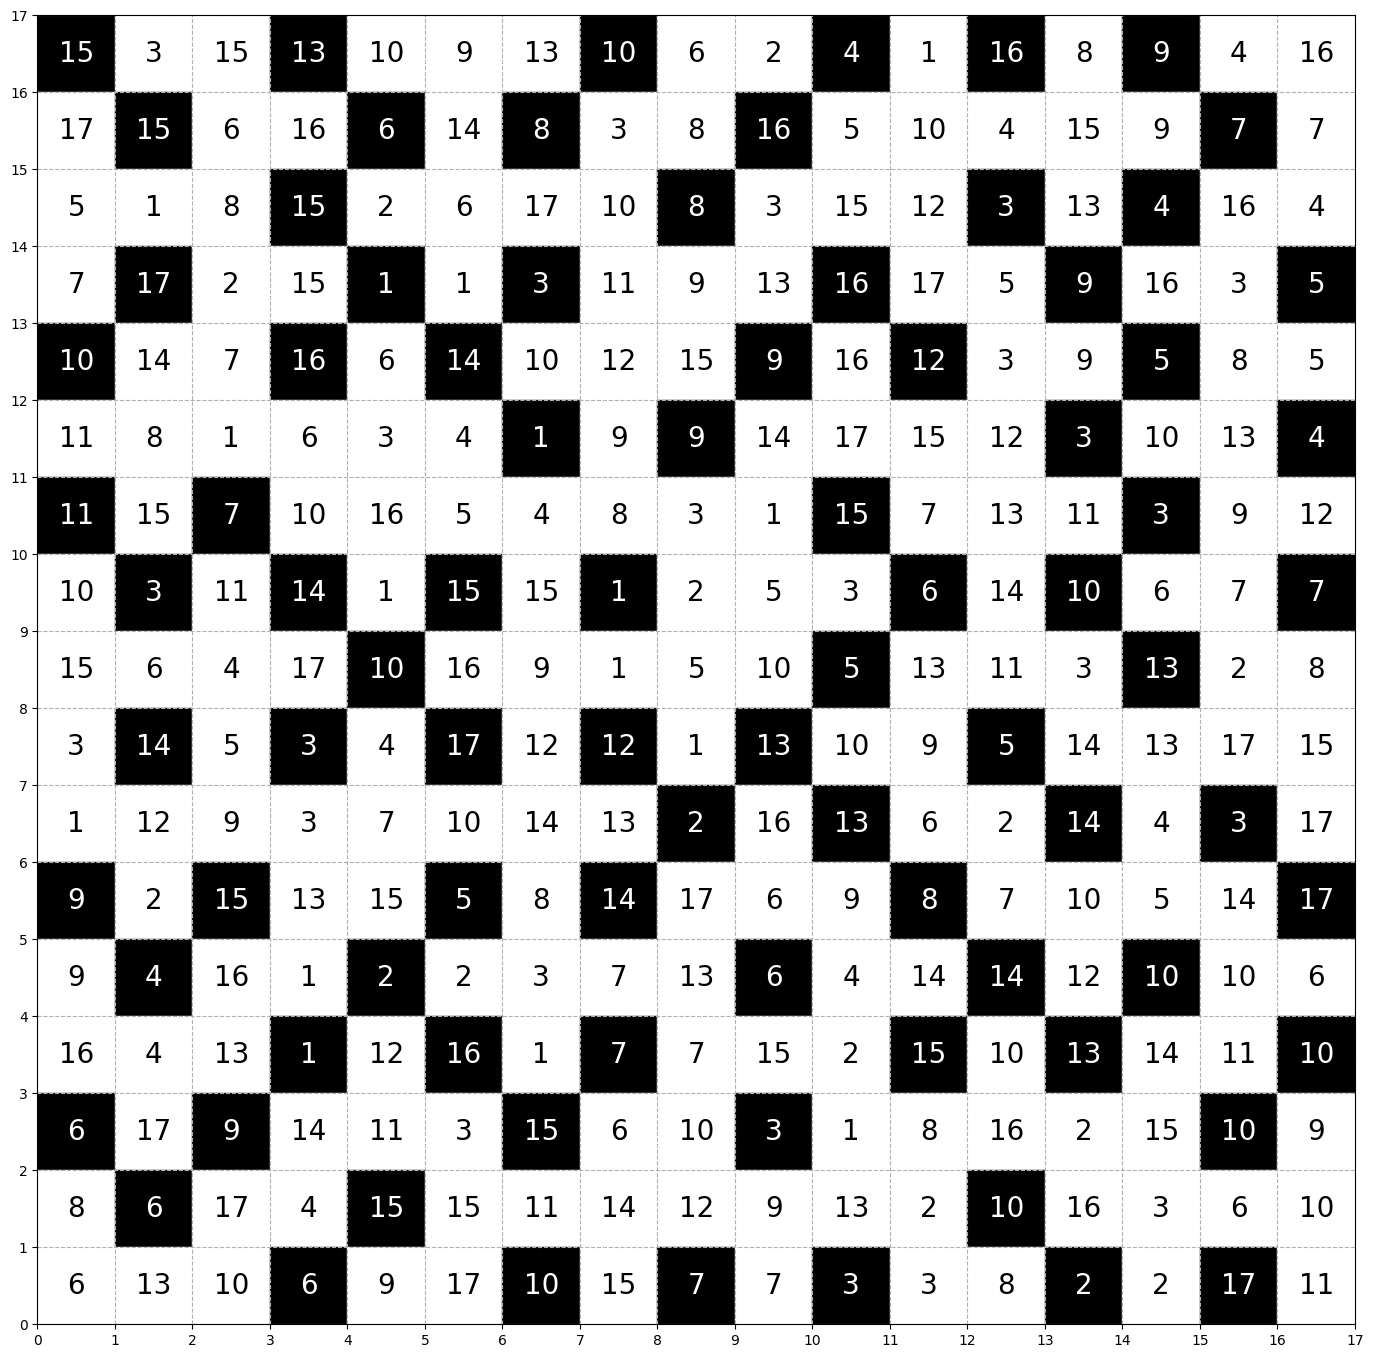

In [31]:
visual(17, 17, grid, result)

## Gurobi solver. (Verified!)

In [ ]:
def HitoriSolver(m, n, grid) :
    
    Hitori = gp.Model("Hitori")
    Hitori.modelSense = gp.GRB.MINIMIZE
    Hitori.Params.lazyConstraints = 1
    Hitori.update()
    x = {}
    
    for i in range(m):
        for j in range(n):
            x[i, j] = Hitori.addVar(
            vtype = gp.GRB.BINARY,
            obj = 1,
            name = f"x[{i},{j}]")
            
    for i in range(m):
        for j in range(n - 1):
            Hitori.addConstr(gp.quicksum([x[i, j], x[i, j + 1]]) <= 1, name = f"r_{i}_{j}")
    for j in range(n):
        for i in range(m - 1):
            Hitori.addConstr(gp.quicksum([x[i, j], x[i + 1, j]]) <= 1, name = f"c_{i}_{j}")
                
    
    for i in range(m):
        pos_dict = dict()
        for j in range(n):
            if grid[i][j] not in pos_dict:
                pos_dict[grid[i][j]] = [(i, j)]
            else:
                pos_dict[grid[i][j]].append((i, j))
        for k, v in pos_dict.items():
            if len(v) > 1:
                Hitori.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in v) >= len(v) - 1, name = f"r{i}_{k}")
    
    for j in range(n):
        pos_dict = dict()
        for i in range(m):
            if grid[i][j] not in pos_dict:
                pos_dict[grid[i][j]] = [(i, j)]
            else:
                pos_dict[grid[i][j]].append((i, j))
        for k, v in pos_dict.items():
            if len(v) > 1:
                Hitori.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in v) >= len(v) - 1, name = f"c{j}_{k}")
    
    Hitori.setObjective(gp.quicksum(x[i, j] for i in range(m) for j in range(n)), gp.GRB.MINIMIZE)
    Hitori.write("Hitori.lp")
    def border_elim(model, where):
        if (where == gp.GRB.Callback.MIPSOL):
            
            x_sol = model.cbGetSolution(model._x)
            curr_grid = [[0] * n for i in range(m)]
            for i in range(m):
                for j in range(n):
                    if x_sol[i, j]== 0:
                        curr_grid[i][j] = 1
                        
            def find_surrounding_black_cells(grid):
                rows, cols = len(grid), len(grid[0])
                visited = set()
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
                total_white = sum(chain.from_iterable(grid))
                # Find the first unvisited white cell
                def find_unvisited_white():
                    for i in range(rows):
                        for j in range(cols):
                            if grid[i][j] == 1 and (i, j) not in visited:
                                return (i, j)
                    return None
                borders_cut = []
                cnt_white = 0
                while len(visited) < total_white:
                    start = find_unvisited_white()
                    if not start:
                        return []

                    # Use BFS to find all connected white cells and record the surrounding black cells
                    queue = deque([start])
                    surrounding_black_cells = set()  # Use a set to avoid duplicates
                    
                    while queue:
                        x, y = queue.popleft()
                        if (x, y) in visited:
                            continue
                        visited.add((x, y))
                        cnt_white += 1
                        # Check all four adjacent directions
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols:
                                if grid[nx][ny] == 1 and (nx, ny) not in visited:
                                    queue.append((nx, ny))
                                elif grid[nx][ny] == 0:
                                    surrounding_black_cells.add((nx, ny))
                    borders_cut.append(list(surrounding_black_cells))

                if cnt_white == sum(chain.from_iterable(grid)) and len(borders_cut) == 1:
                    return []
                borders_cut.sort(key=lambda x: len(x))
                return borders_cut

            borders_cut = find_surrounding_black_cells(curr_grid)
            for cut in borders_cut:
                print("ADD Cut")
                model.cbLazy(gp.quicksum(x[subx, suby] for (subx, suby) in cut ) <= len(cut) - 1)
    
    Hitori._x = x
    Hitori.optimize(border_elim)
    Hitori.optimize()
    # Visualize 
    result = ""
    
    for i in range(m):
        for j in range(n):
            if x[i, j].x > 1e-6:
                print("X", end = " ")
                result += "X"
            else:
                print("0", end = " ")
                result += "0"
        print()
    print()
    return result

## Visualization

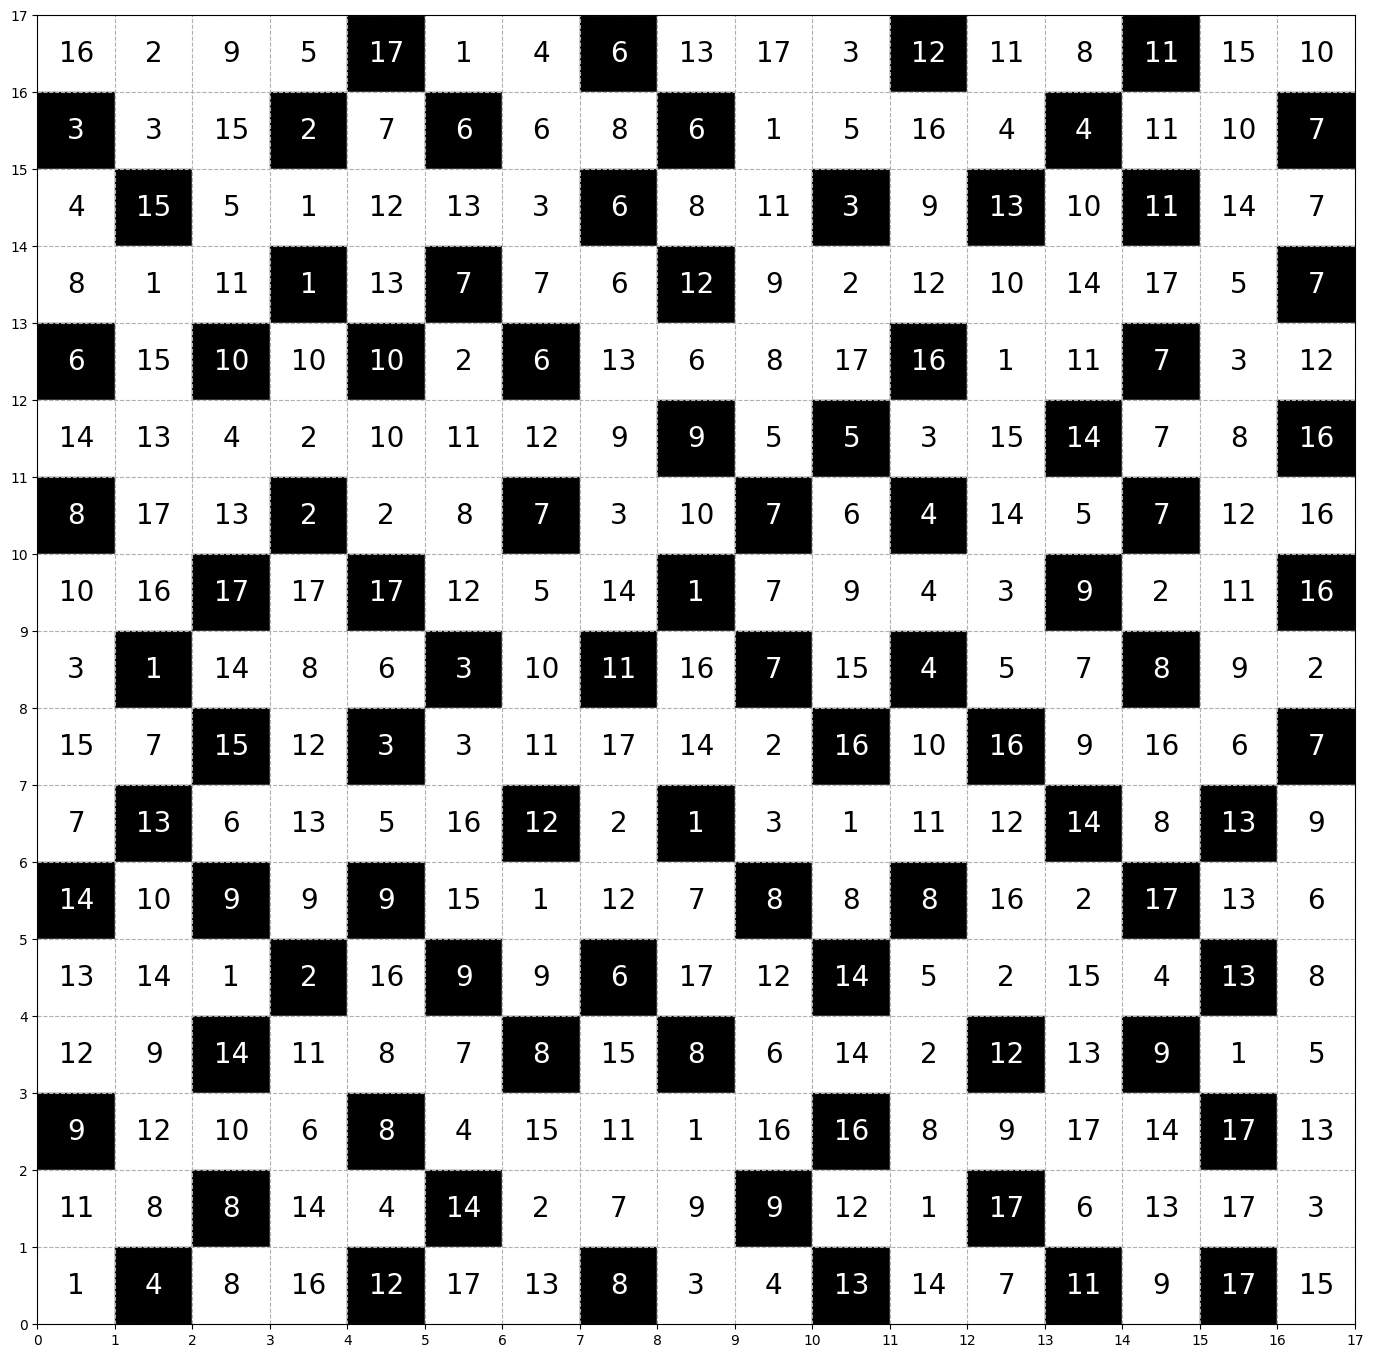

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import MultipleLocator

def visual(X, Y, grid, result):
    plt.figure(figsize = (Y, X))
    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    ax.yaxis.set_major_locator(y_major_locator)
    plt.xlim(0,Y)
    plt.ylim(0,X)
    plt.grid(linestyle = "--")
    for i in range(X):
        for j in range(Y):
            if result[i * Y + j] == "X":
                ax.add_patch(Rectangle((j, X - i - 1), 1, 1, color = "#000000"))
            elif result[i * Y + j] == "0":
                ax.add_patch(Rectangle((j, X - i - 1), 1, 1, color = "#ffffff"))
    for i in range(X):
        for j in range(Y):
            if result[i * Y + j] == "X":
                ax.text(j + 0.5, X - i - 0.5, grid[i][j], 
                        horizontalalignment = "center", 
                        verticalalignment = 'center',
                        fontsize = 20, color = "#ffffff")
            elif result[i * Y + j] == "0":
                ax.text(j + 0.5, X - i - 0.5, grid[i][j], 
                        horizontalalignment = "center", 
                        verticalalignment = 'center',
                        fontsize = 20, color = "#000000")
    plt.show()
    

if __name__ == "__main__":
    visual(17, 17, grid, result)
    

In [12]:
result

'0000X00X000000X00X00X00X0X00X0X00X0X00000000X0X0X00000X0X0X000X0X00XX0X0X0X0000000X0000000000X0X00X00XX00X00X00X0X00X0000X0X000X0000X00X0X000X0X0X0X00X0000X0X00000X0X000X0X0000X0X000000X0X0X0X0000X0X00X00000X0X0X00X0000X000X000X0X000X0X00X000X00000X0000X000X00X000X00X00000X00X00X00X00X0X0'